# Imports and Functions

In [1]:
import math 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KDTree
%matplotlib notebook

global selection_model
import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 3 #0 for 0.5, 1 for isolated, 2 for random, 3 for best

global threshold_low1, threshold_high1, threshold_low2, threshold_high2
threshold_low1 = 0 #300 works
threshold_high1 = 60
threshold_low2 = 500 #300 works
threshold_high2 = 2000

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def xnew(x): 
    return (-5+(((x+5)*(5--5))/(51+5)))
def ynew(y): 
    return (-5+(((y+2)*(5--5))/(53+2)))

def hblau(x):
       
#     return ((1.5-(x[0])+(x[0]*x[1]))**2)+ ((2.25-(x[0])+(x[0]*(x[1]**2)))**2)+ ((2.625-(x[0])+(x[0]*(x[1]**3)))**2)
    return ((((x[0]**2)+(x[1])-11)**2)+(((x[0])+((x[1])**2)-7)**2))

def hblauColor(x, threshold_low1, threshold_high1, threshold_low2, threshold_high2):
    
    if (threshold_low1<hblau((xnew(x[0]),xnew(x[1])))<threshold_high1)|(threshold_low2<hblau((xnew(x[0]),xnew(x[1])))<threshold_high2):
        return 1
    else:
        return 0
      

In [4]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global Zhblau
    global xx,yy
    global Big_df
    global Big_df_land


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .2  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = ExtraTreesClassifier(n_estimators = 100)
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    Zhblau = []
    hblaucoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(77000):
        Zhblau.append(hblauColor(hblaucoords[i],threshold_low1,threshold_high1,threshold_low2,threshold_high2))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', Zhblau)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(77000):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


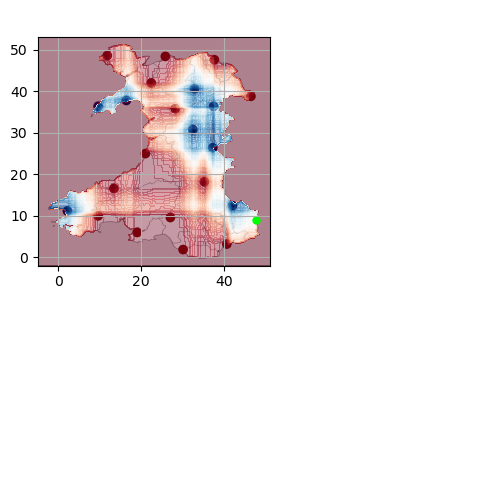

iteration  1
Accuracy is 0.42221607329521
iteration  2
Accuracy is 0.3800344339912685
iteration  3
Accuracy is 0.3939310090389227
iteration  4
Accuracy is 0.4333148865522966
iteration  5
Accuracy is 0.7772243743466765
iteration  6
Accuracy is 0.7305232736887413
iteration  7
Accuracy is 0.7446350611818238
iteration  8
Accuracy is 0.7484781405644715
iteration  9
Accuracy is 0.8013589128697043
iteration  10
Accuracy is 0.7616368443706574
iteration  11
Accuracy is 0.7813134108098136
iteration  12
Accuracy is 0.8257086638381602
iteration  13
Accuracy is 0.8012974235995819
iteration  14
Accuracy is 0.7938264772797147
iteration  15
Accuracy is 0.8458156551681731
iteration  16
Accuracy is 0.8357314148681055
iteration  17
Accuracy is 0.8166082518600504
iteration  18
Accuracy is 0.8171616552911517
iteration  19
Accuracy is 0.8435712968087069
iteration  20
Accuracy is 0.8248785586915083
iteration  21
Accuracy is 0.8589128697042366
experiment:  1


<IPython.core.display.Javascript object>


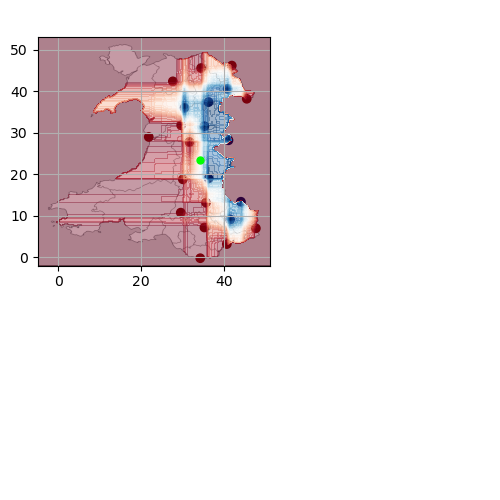

iteration  1
Accuracy is 0.6401340466088667
iteration  2
Accuracy is 0.7225604132078952
iteration  3
Accuracy is 0.8174998462768247
iteration  4
Accuracy is 0.8401586423169157
iteration  5
Accuracy is 0.8339789706696181
iteration  6
Accuracy is 0.7937957326446535
iteration  7
Accuracy is 0.8464305478693968
iteration  8
Accuracy is 0.8467072495849475
iteration  9
Accuracy is 0.8415421508946689
iteration  10
Accuracy is 0.85795978601734
iteration  11
Accuracy is 0.8527946873270614
iteration  12
Accuracy is 0.8381909856730001
iteration  13
Accuracy is 0.8435405521736457
iteration  14
Accuracy is 0.8322265264711308
iteration  15
Accuracy is 0.8243558998954682
iteration  16
Accuracy is 0.8492283096599643
iteration  17
Accuracy is 0.8340097153046794
iteration  18
Accuracy is 0.8551927688618336
iteration  19
Accuracy is 0.8611264834286417
iteration  20
Accuracy is 0.8634015864231691
iteration  21
Accuracy is 0.8593432945950932
experiment:  2


<IPython.core.display.Javascript object>


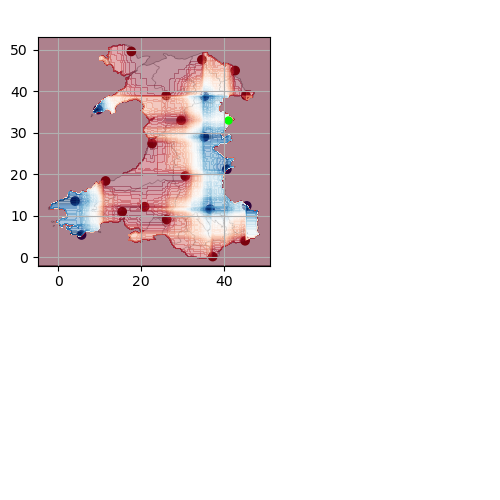

iteration  1
Accuracy is 0.39248601119104715
iteration  2
Accuracy is 0.4013712107237287
iteration  3
Accuracy is 0.40269323003135954
iteration  4
Accuracy is 0.4059521613478448
iteration  5
Accuracy is 0.5004919141609789
iteration  6
Accuracy is 0.7458955912193322
iteration  7
Accuracy is 0.6841911086515403
iteration  8
Accuracy is 0.669433683822173
iteration  9
Accuracy is 0.6509869027854639
iteration  10
Accuracy is 0.6915083317961016
iteration  11
Accuracy is 0.7728893808030499
iteration  12
Accuracy is 0.7786386275594909
iteration  13
Accuracy is 0.8174998462768247
iteration  14
Accuracy is 0.8394207710754473
iteration  15
Accuracy is 0.8630941400725574
iteration  16
Accuracy is 0.8448318268462154
iteration  17
Accuracy is 0.8486749062288631
iteration  18
Accuracy is 0.8466457603148251
iteration  19
Accuracy is 0.8424644899465044
iteration  20
Accuracy is 0.8622332902908443
iteration  21
Accuracy is 0.8389288569144684
experiment:  3


<IPython.core.display.Javascript object>


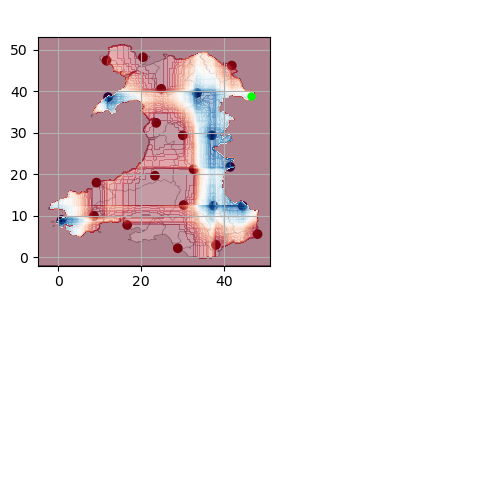

iteration  1
Accuracy is 0.597060812888151
iteration  2
Accuracy is 0.6661440078706266
iteration  3
Accuracy is 0.7318452929963721
iteration  4
Accuracy is 0.7934267970239193
iteration  5
Accuracy is 0.7596384430916805
iteration  6
Accuracy is 0.7042058660763697
iteration  7
Accuracy is 0.6182131218102441
iteration  8
Accuracy is 0.5985058107360266
iteration  9
Accuracy is 0.6744758039722069
iteration  10
Accuracy is 0.7387320912500769
iteration  11
Accuracy is 0.7837114923445859
iteration  12
Accuracy is 0.825831642378405
iteration  13
Accuracy is 0.8460923568837238
iteration  14
Accuracy is 0.8523027731660825
iteration  15
Accuracy is 0.8713029576338929
iteration  16
Accuracy is 0.8605115907274181
iteration  17
Accuracy is 0.844770337576093
iteration  18
Accuracy is 0.8775133739162516
iteration  19
Accuracy is 0.8757301850827031
iteration  20
Accuracy is 0.8721945520506672
iteration  21
Accuracy is 0.8839082580089774
experiment:  4


<IPython.core.display.Javascript object>


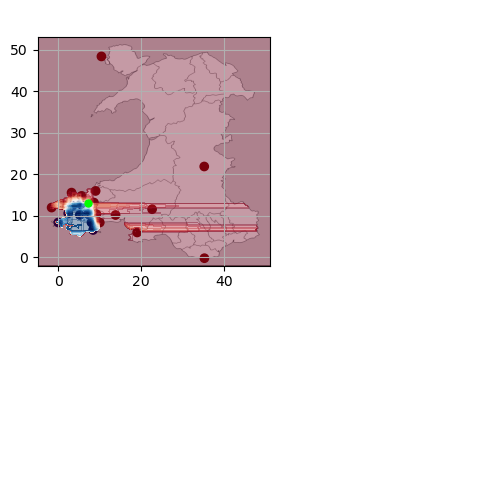

iteration  1
Accuracy is 0.5157105085162639
iteration  2
Accuracy is 0.6222099243681978
iteration  3
Accuracy is 0.6938756686958126
iteration  4
Accuracy is 0.7173953145176166
iteration  5
Accuracy is 0.7138904261206419
iteration  6
Accuracy is 0.7278484904384185
iteration  7
Accuracy is 0.7237287093402202
iteration  8
Accuracy is 0.7330135891286971
iteration  9
Accuracy is 0.7317530590911886
iteration  10
Accuracy is 0.731138166389965
iteration  11
Accuracy is 0.728770829490254
iteration  12
Accuracy is 0.730123593432946
iteration  13
Accuracy is 0.7326753981430241
iteration  14
Accuracy is 0.7294164668265388
iteration  15
Accuracy is 0.7329213552235135
iteration  16
Accuracy is 0.7352886921232245
iteration  17
Accuracy is 0.7359958187296317
iteration  18
Accuracy is 0.7357806062842034
iteration  19
Accuracy is 0.7365492221607329
iteration  20
Accuracy is 0.7367029453360389
iteration  21
Accuracy is 0.7379634753735473
experiment:  5


<IPython.core.display.Javascript object>


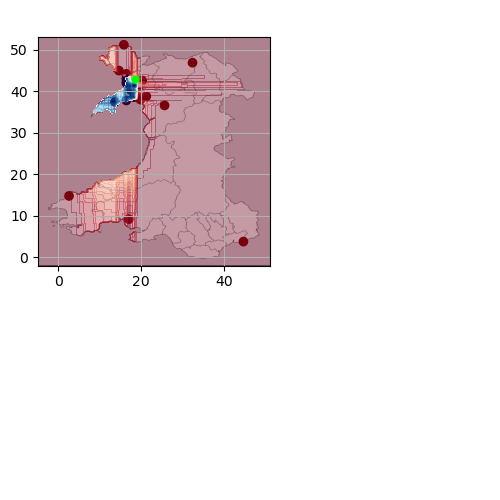

iteration  1
Accuracy is 0.34394023242944105
iteration  2
Accuracy is 0.595369857959786
iteration  3
Accuracy is 0.6840988747463568
iteration  4
Accuracy is 0.6878804648588821
iteration  5
Accuracy is 0.7146282973621103
iteration  6
Accuracy is 0.7205620119289184
iteration  7
Accuracy is 0.7177642501383509
iteration  8
Accuracy is 0.7250199840127898
iteration  9
Accuracy is 0.7210846707249585
iteration  10
Accuracy is 0.7238516878804648
iteration  11
Accuracy is 0.7276947672631126
iteration  12
Accuracy is 0.7283404045993974
iteration  13
Accuracy is 0.7272335977371949
iteration  14
Accuracy is 0.727602533357929
iteration  15
Accuracy is 0.7281251921539691
iteration  16
Accuracy is 0.7268646621164607
iteration  17
Accuracy is 0.7282174260591526
iteration  18
Accuracy is 0.7284018938695198
iteration  19
Accuracy is 0.7285556170448256
iteration  20
Accuracy is 0.7282174260591526
iteration  21
Accuracy is 0.728617106314948
experiment:  6


<IPython.core.display.Javascript object>


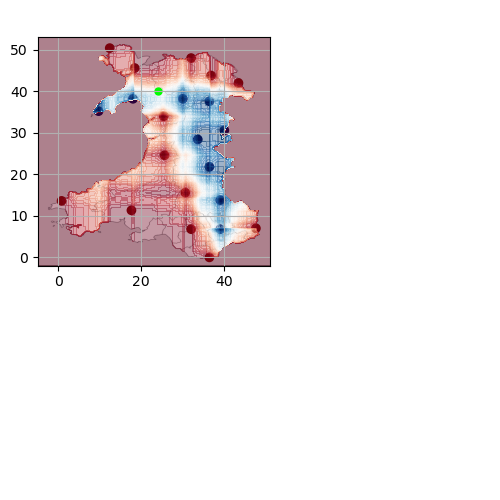

iteration  1
Accuracy is 0.5931562442353809
iteration  2
Accuracy is 0.5418127036832073
iteration  3
Accuracy is 0.4443829551743221
iteration  4
Accuracy is 0.5262866629773104
iteration  5
Accuracy is 0.6170755703129804
iteration  6
Accuracy is 0.6700793211584578
iteration  7
Accuracy is 0.6662977310459325
iteration  8
Accuracy is 0.7666482198856299
iteration  9
Accuracy is 0.805201992252352
iteration  10
Accuracy is 0.8051097583471685
iteration  11
Accuracy is 0.7900448871671893
iteration  12
Accuracy is 0.7792227756256533
iteration  13
Accuracy is 0.8126729385722191
iteration  14
Accuracy is 0.8415114062596077
iteration  15
Accuracy is 0.8311197196089283
iteration  16
Accuracy is 0.833456311873578
iteration  17
Accuracy is 0.8255241960277931
iteration  18
Accuracy is 0.8365615200147575
iteration  19
Accuracy is 0.857621595031667
iteration  20
Accuracy is 0.8272458955912193
iteration  21
Accuracy is 0.8164545286847446
experiment:  7


<IPython.core.display.Javascript object>


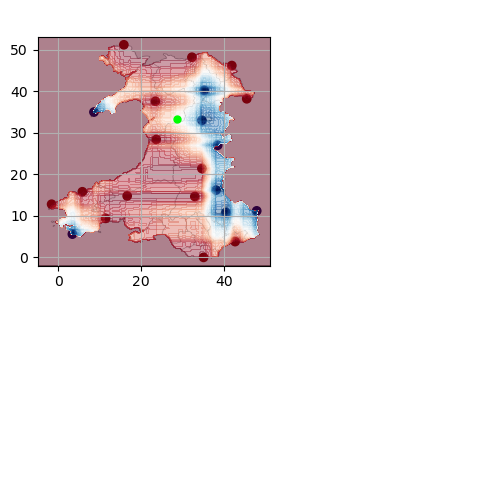

iteration  1
Accuracy is 0.8027116768123962
iteration  2
Accuracy is 0.7748877820820267
iteration  3
Accuracy is 0.7191785033511652
iteration  4
Accuracy is 0.6356760745249954
iteration  5
Accuracy is 0.501690954928365
iteration  6
Accuracy is 0.6711861280206604
iteration  7
Accuracy is 0.69953268154707
iteration  8
Accuracy is 0.7382094324540368
iteration  9
Accuracy is 0.7477710139580643
iteration  10
Accuracy is 0.7928426489577569
iteration  11
Accuracy is 0.8587898911639918
iteration  12
Accuracy is 0.857621595031667
iteration  13
Accuracy is 0.8585439340835024
iteration  14
Accuracy is 0.8139027239746665
iteration  15
Accuracy is 0.8561458525487302
iteration  16
Accuracy is 0.8452007624669495
iteration  17
Accuracy is 0.8334255672385169
iteration  18
Accuracy is 0.8555002152124455
iteration  19
Accuracy is 0.8645083932853717
iteration  20
Accuracy is 0.8926089897312919
iteration  21
Accuracy is 0.8928549468117813
experiment:  8


<IPython.core.display.Javascript object>


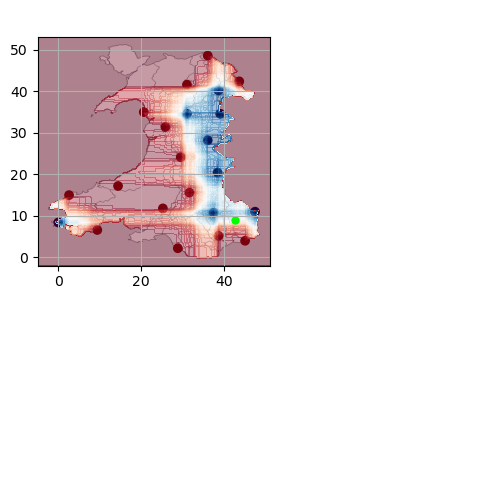

iteration  1
Accuracy is 0.7217917973313657
iteration  2
Accuracy is 0.5353563303203591
iteration  3
Accuracy is 0.6294041689725143
iteration  4
Accuracy is 0.6824079198179918
iteration  5
Accuracy is 0.7623747156121257
iteration  6
Accuracy is 0.7455266555985981
iteration  7
Accuracy is 0.7525364323925475
iteration  8
Accuracy is 0.7928119043226957
iteration  9
Accuracy is 0.791182438664453
iteration  10
Accuracy is 0.8058476295886368
iteration  11
Accuracy is 0.8177458033573142
iteration  12
Accuracy is 0.8253704728524872
iteration  13
Accuracy is 0.840712045748017
iteration  14
Accuracy is 0.8169771874807846
iteration  15
Accuracy is 0.8319498247555801
iteration  16
Accuracy is 0.7995449794010945
iteration  17
Accuracy is 0.8267847260653016
iteration  18
Accuracy is 0.8204820758777593
iteration  19
Accuracy is 0.825493451392732
iteration  20
Accuracy is 0.8530406444075509
iteration  21
Accuracy is 0.8562380864539137
experiment:  9


<IPython.core.display.Javascript object>


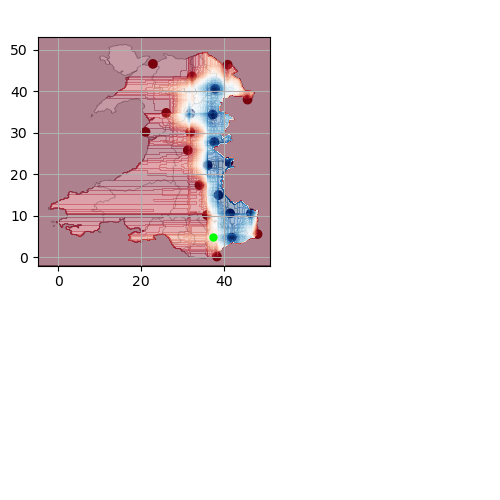

iteration  1
Accuracy is 0.6189202484166513
iteration  2
Accuracy is 0.6508946688802804
iteration  3
Accuracy is 0.636629158211892
iteration  4
Accuracy is 0.7261882801451147
iteration  5
Accuracy is 0.7210231814548361
iteration  6
Accuracy is 0.7026071450531882
iteration  7
Accuracy is 0.7140441492959478
iteration  8
Accuracy is 0.7135522351349689
iteration  9
Accuracy is 0.7548730246571973
iteration  10
Accuracy is 0.782543196212261
iteration  11
Accuracy is 0.7917050974604931
iteration  12
Accuracy is 0.8443399126852364
iteration  13
Accuracy is 0.8442169341449917
iteration  14
Accuracy is 0.8452622517370719
iteration  15
Accuracy is 0.8811719854885323
iteration  16
Accuracy is 0.8411117260038123
iteration  17
Accuracy is 0.8418495972452807
iteration  18
Accuracy is 0.8714566808091988
iteration  19
Accuracy is 0.8752997601918465
iteration  20
Accuracy is 0.8539937280944475
iteration  21
Accuracy is 0.8749308245711124
experiment:  10


<IPython.core.display.Javascript object>


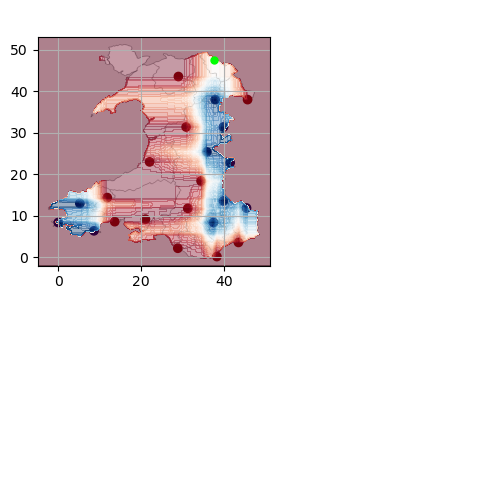

iteration  1
Accuracy is 0.7041443768062473
iteration  2
Accuracy is 0.4524687941954129
iteration  3
Accuracy is 0.5616737379327308
iteration  4
Accuracy is 0.5995203836930456
iteration  5
Accuracy is 0.7018692738117198
iteration  6
Accuracy is 0.7865707434052758
iteration  7
Accuracy is 0.7453729324232922
iteration  8
Accuracy is 0.7606530160486995
iteration  9
Accuracy is 0.7636659902846953
iteration  10
Accuracy is 0.7716903400356637
iteration  11
Accuracy is 0.7572403615569083
iteration  12
Accuracy is 0.7595154645514358
iteration  13
Accuracy is 0.7486011191047163
iteration  14
Accuracy is 0.7621287585316362
iteration  15
Accuracy is 0.7636659902846953
iteration  16
Accuracy is 0.7799299022320605
iteration  17
Accuracy is 0.7993605115907274
iteration  18
Accuracy is 0.8354239685174937
iteration  19
Accuracy is 0.8300129127467257
iteration  20
Accuracy is 0.8400971530467933
iteration  21
Accuracy is 0.8741007194244604
experiment:  11


<IPython.core.display.Javascript object>


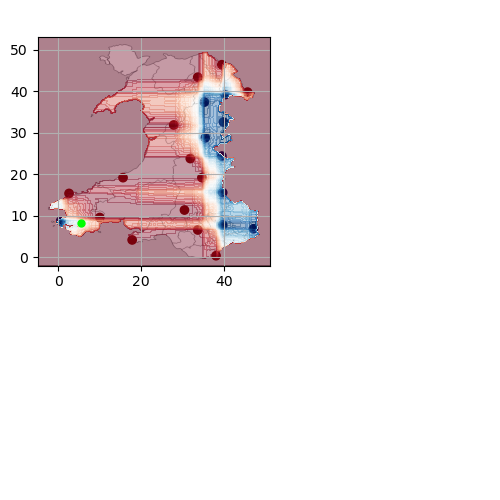

iteration  1
Accuracy is 0.6434544671954744
iteration  2
Accuracy is 0.5046424398942384
iteration  3
Accuracy is 0.6446535079628605
iteration  4
Accuracy is 0.7072188403123655
iteration  5
Accuracy is 0.7481706942138597
iteration  6
Accuracy is 0.75988440017217
iteration  7
Accuracy is 0.7405152800836254
iteration  8
Accuracy is 0.7437434667650495
iteration  9
Accuracy is 0.7817438357006702
iteration  10
Accuracy is 0.7804218163930394
iteration  11
Accuracy is 0.8085531574740208
iteration  12
Accuracy is 0.842403000676382
iteration  13
Accuracy is 0.8184836745987825
iteration  14
Accuracy is 0.8218655844555125
iteration  15
Accuracy is 0.8269691938756687
iteration  16
Accuracy is 0.8288446166144008
iteration  17
Accuracy is 0.8465227817745803
iteration  18
Accuracy is 0.8661378589436144
iteration  19
Accuracy is 0.8635860542335363
iteration  20
Accuracy is 0.8555617044825677
iteration  21
Accuracy is 0.8642009469347599
experiment:  12


<IPython.core.display.Javascript object>


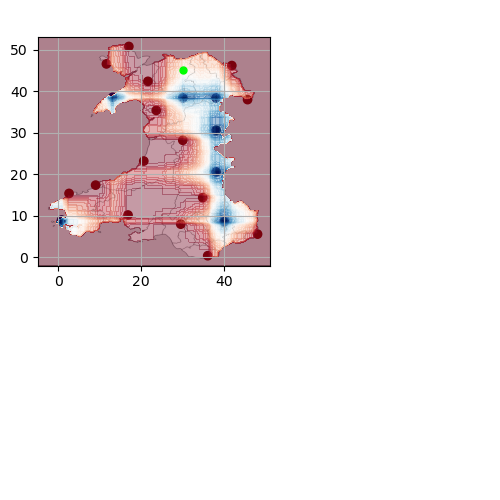

iteration  1
Accuracy is 0.48493512882002093
iteration  2
Accuracy is 0.4161593801881572
iteration  3
Accuracy is 0.5222283711492345
iteration  4
Accuracy is 0.5831334932054356
iteration  5
Accuracy is 0.5664084117321527
iteration  6
Accuracy is 0.6250384307938265
iteration  7
Accuracy is 0.6744450593371457
iteration  8
Accuracy is 0.7301543380680071
iteration  9
Accuracy is 0.758531636229478
iteration  10
Accuracy is 0.7593002521060075
iteration  11
Accuracy is 0.7612986533849844
iteration  12
Accuracy is 0.7901986103424953
iteration  13
Accuracy is 0.8404045993974052
iteration  14
Accuracy is 0.8461538461538461
iteration  15
Accuracy is 0.8578060628420341
iteration  16
Accuracy is 0.9149295947857099
iteration  17
Accuracy is 0.9160364016479124
iteration  18
Accuracy is 0.8752997601918465
iteration  19
Accuracy is 0.8709340220131587
iteration  20
Accuracy is 0.8902109081965197
iteration  21
Accuracy is 0.8761913546086207
experiment:  13


<IPython.core.display.Javascript object>


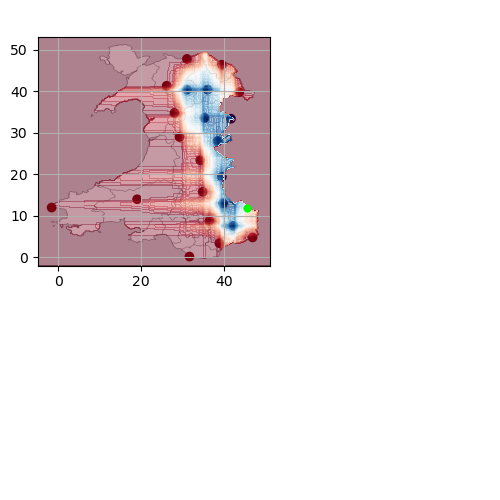

iteration  1
Accuracy is 0.6776425013835086
iteration  2
Accuracy is 0.6815163254012175
iteration  3
Accuracy is 0.7549652585623808
iteration  4
Accuracy is 0.7622824817069421
iteration  5
Accuracy is 0.8337022689540675
iteration  6
Accuracy is 0.8190063333948226
iteration  7
Accuracy is 0.7883231876037632
iteration  8
Accuracy is 0.7817745803357314
iteration  9
Accuracy is 0.7661870503597122
iteration  10
Accuracy is 0.752782389473037
iteration  11
Accuracy is 0.7664330074402017
iteration  12
Accuracy is 0.7985611510791367
iteration  13
Accuracy is 0.8325647174568038
iteration  14
Accuracy is 0.8427719362971161
iteration  15
Accuracy is 0.8420955543257701
iteration  16
Accuracy is 0.8505810736026563
iteration  17
Accuracy is 0.8794195412900448
iteration  18
Accuracy is 0.8466457603148251
iteration  19
Accuracy is 0.8677058353317346
iteration  20
Accuracy is 0.8652155198917789
iteration  21
Accuracy is 0.8543934083502429
experiment:  14


<IPython.core.display.Javascript object>


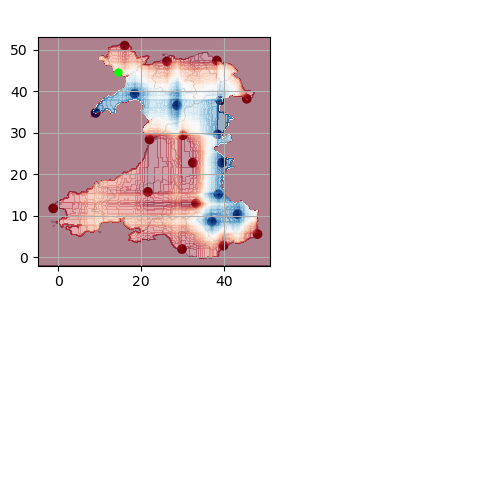

iteration  1
Accuracy is 0.5454713152554879
iteration  2
Accuracy is 0.6774580335731415
iteration  3
Accuracy is 0.791182438664453
iteration  4
Accuracy is 0.809936666051774
iteration  5
Accuracy is 0.7984381725388919
iteration  6
Accuracy is 0.7935497755641641
iteration  7
Accuracy is 0.7721515095615815
iteration  8
Accuracy is 0.7889688249400479
iteration  9
Accuracy is 0.8151632540121748
iteration  10
Accuracy is 0.8039107175797823
iteration  11
Accuracy is 0.8362233290290845
iteration  12
Accuracy is 0.8281989792781159
iteration  13
Accuracy is 0.8426182131218103
iteration  14
Accuracy is 0.7788845846399803
iteration  15
Accuracy is 0.7792535202607145
iteration  16
Accuracy is 0.751767816516018
iteration  17
Accuracy is 0.7965934944352211
iteration  18
Accuracy is 0.7830351103732399
iteration  19
Accuracy is 0.7909364815839636
iteration  20
Accuracy is 0.8286601488040337
iteration  21
Accuracy is 0.8327184406321096
experiment:  15


<IPython.core.display.Javascript object>


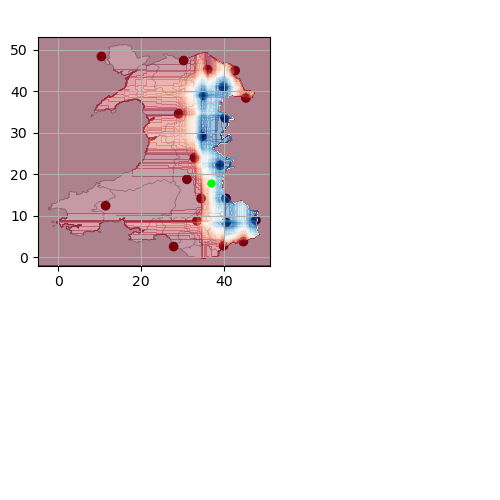

iteration  1
Accuracy is 0.5304986779806924
iteration  2
Accuracy is 0.4524073049252905
iteration  3
Accuracy is 0.5529730062104162
iteration  4
Accuracy is 0.5890979524073049
iteration  5
Accuracy is 0.7736579966795795
iteration  6
Accuracy is 0.8345938633708417
iteration  7
Accuracy is 0.8276148312119536
iteration  8
Accuracy is 0.8084916682038984
iteration  9
Accuracy is 0.8222652647113079
iteration  10
Accuracy is 0.8386521551989178
iteration  11
Accuracy is 0.8516571358297977
iteration  12
Accuracy is 0.8614646744143147
iteration  13
Accuracy is 0.8545163868904876
iteration  14
Accuracy is 0.8419725757855254
iteration  15
Accuracy is 0.8408657689233229
iteration  16
Accuracy is 0.8448625714812765
iteration  17
Accuracy is 0.8636782881387198
iteration  18
Accuracy is 0.8717948717948718
iteration  19
Accuracy is 0.8704728524872409
iteration  20
Accuracy is 0.8667220070097768
iteration  21
Accuracy is 0.8719178503351165
experiment:  16


<IPython.core.display.Javascript object>


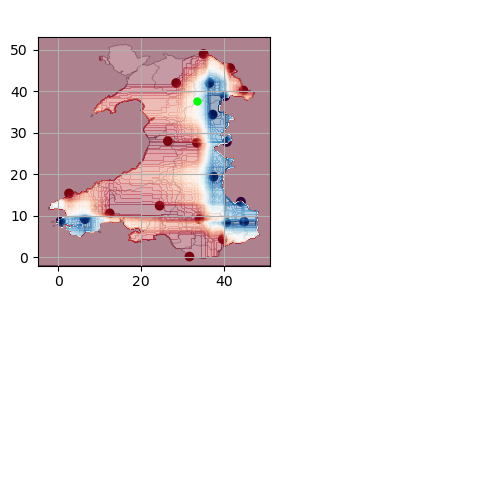

iteration  1
Accuracy is 0.6486810551558753
iteration  2
Accuracy is 0.6389350058414807
iteration  3
Accuracy is 0.6474820143884892
iteration  4
Accuracy is 0.6670970915575232
iteration  5
Accuracy is 0.6830228125192154
iteration  6
Accuracy is 0.7491852671708786
iteration  7
Accuracy is 0.7561642993297669
iteration  8
Accuracy is 0.7442968701961508
iteration  9
Accuracy is 0.7444198487363956
iteration  10
Accuracy is 0.7614831211953514
iteration  11
Accuracy is 0.7808829859189571
iteration  12
Accuracy is 0.8235872840189387
iteration  13
Accuracy is 0.8160855930640103
iteration  14
Accuracy is 0.8201131402570252
iteration  15
Accuracy is 0.8587898911639918
iteration  16
Accuracy is 0.8682899833978971
iteration  17
Accuracy is 0.8699809383262621
iteration  18
Accuracy is 0.8543011744450594
iteration  19
Accuracy is 0.8518416036401648
iteration  20
Accuracy is 0.8629404168972514
iteration  21
Accuracy is 0.8724097644960954
experiment:  17


<IPython.core.display.Javascript object>


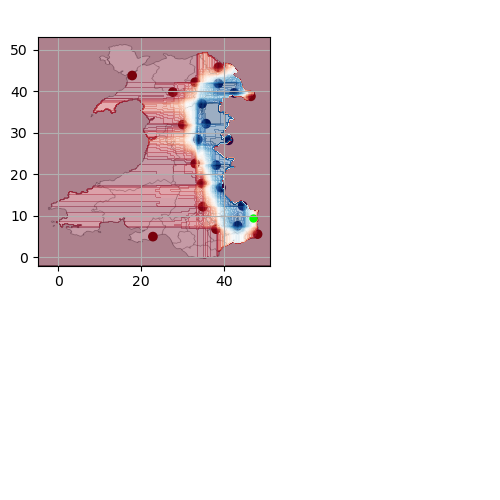

iteration  1
Accuracy is 0.402600996126176
iteration  2
Accuracy is 0.5502059890549099
iteration  3
Accuracy is 0.8660456250384307
iteration  4
Accuracy is 0.7538277070651171
iteration  5
Accuracy is 0.8192215458402509
iteration  6
Accuracy is 0.803019123163008
iteration  7
Accuracy is 0.7787308614646744
iteration  8
Accuracy is 0.7732275717887229
iteration  9
Accuracy is 0.7988993420648097
iteration  10
Accuracy is 0.8396052388858144
iteration  11
Accuracy is 0.8290598290598291
iteration  12
Accuracy is 0.8430178933776056
iteration  13
Accuracy is 0.8321650372010084
iteration  14
Accuracy is 0.8346553526409641
iteration  15
Accuracy is 0.8483367152431901
iteration  16
Accuracy is 0.8495357560105762
iteration  17
Accuracy is 0.8618336100350489
iteration  18
Accuracy is 0.8591895714197872
iteration  19
Accuracy is 0.8566685113447703
iteration  20
Accuracy is 0.8614339297792535
iteration  21
Accuracy is 0.8578368074770952
experiment:  18


<IPython.core.display.Javascript object>


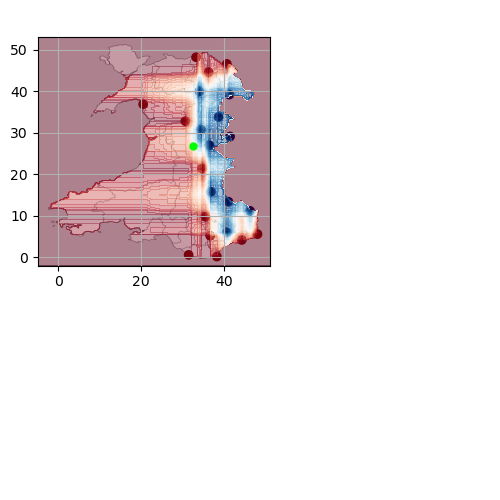

iteration  1
Accuracy is 0.41483736088052636
iteration  2
Accuracy is 0.7219455205066716
iteration  3
Accuracy is 0.7735350181393347
iteration  4
Accuracy is 0.7483551620242268
iteration  5
Accuracy is 0.7191785033511652
iteration  6
Accuracy is 0.7899219086269446
iteration  7
Accuracy is 0.7693230031359528
iteration  8
Accuracy is 0.7581627006087438
iteration  9
Accuracy is 0.7630203529484105
iteration  10
Accuracy is 0.7600381233474759
iteration  11
Accuracy is 0.7989300866998709
iteration  12
Accuracy is 0.8311504642439894
iteration  13
Accuracy is 0.8295209985857468
iteration  14
Accuracy is 0.8391440693598967
iteration  15
Accuracy is 0.8429564041074833
iteration  16
Accuracy is 0.8635245649634139
iteration  17
Accuracy is 0.8509192645883293
iteration  18
Accuracy is 0.864231691569821
iteration  19
Accuracy is 0.8673061550759392
iteration  20
Accuracy is 0.8756686958125807
iteration  21
Accuracy is 0.8586669126237472
experiment:  19


<IPython.core.display.Javascript object>


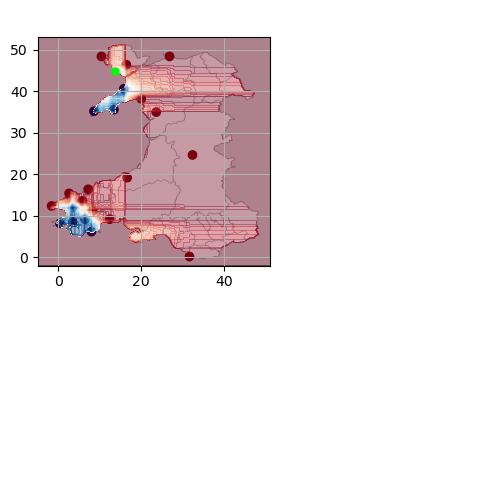

iteration  1
Accuracy is 0.5466703560228741
iteration  2
Accuracy is 0.6304802311996557
iteration  3
Accuracy is 0.5518354547131525
iteration  4
Accuracy is 0.657074340527578
iteration  5
Accuracy is 0.7228678595585071
iteration  6
Accuracy is 0.7134600012297854
iteration  7
Accuracy is 0.7290167865707434
iteration  8
Accuracy is 0.7264649818606653
iteration  9
Accuracy is 0.7335977371948595
iteration  10
Accuracy is 0.7444505933714567
iteration  11
Accuracy is 0.717610526963045
iteration  12
Accuracy is 0.7366722007009777
iteration  13
Accuracy is 0.7463875053803112
iteration  14
Accuracy is 0.7446658058168849
iteration  15
Accuracy is 0.7427596384430917
iteration  16
Accuracy is 0.7437742114001107
iteration  17
Accuracy is 0.7513681362602226
iteration  18
Accuracy is 0.7492775010760623
iteration  19
Accuracy is 0.7525056877574863
iteration  20
Accuracy is 0.7555801512636044
iteration  21
Accuracy is 0.7519215396913239
experiment:  20


<IPython.core.display.Javascript object>


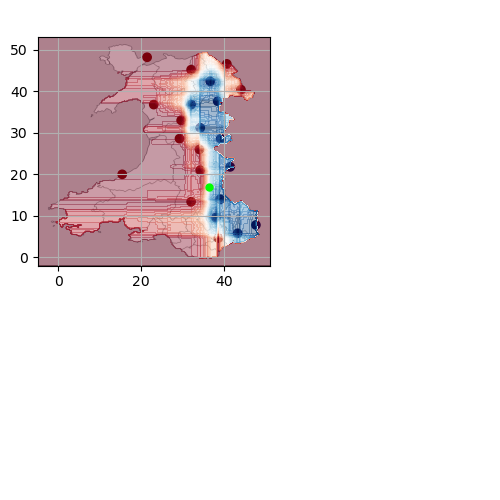

iteration  1
Accuracy is 0.7600996126175982
iteration  2
Accuracy is 0.5893131648527332
iteration  3
Accuracy is 0.6914160978909181
iteration  4
Accuracy is 0.8063395437496157
iteration  5
Accuracy is 0.8006210416282359
iteration  6
Accuracy is 0.8091373055401833
iteration  7
Accuracy is 0.7929348828629404
iteration  8
Accuracy is 0.8077845415974912
iteration  9
Accuracy is 0.8395744942507533
iteration  10
Accuracy is 0.8448625714812765
iteration  11
Accuracy is 0.8763450777839267
iteration  12
Accuracy is 0.8653384984320236
iteration  13
Accuracy is 0.8671216872655721
iteration  14
Accuracy is 0.8683822173030806
iteration  15
Accuracy is 0.8671216872655721
iteration  16
Accuracy is 0.8763450777839267
iteration  17
Accuracy is 0.8776363524564963
iteration  18
Accuracy is 0.8809260284080428
iteration  19
Accuracy is 0.8783127344278423
iteration  20
Accuracy is 0.8739777408842158
iteration  21
Accuracy is 0.8764373116891102


In [7]:
from random import randint
import time

valid_seeds = [27,12,15,21,25,36,37,41,45,48,50,51,52,53,54,57,61,63,64,71,75]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            hblauColor(landpoints[value],threshold_low1,threshold_high1,threshold_low2,threshold_high2)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], hblauColor(nextpoint,threshold_low1,threshold_high1,threshold_low2,threshold_high2)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [8]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 88.09 %
Improvement is = 12.08 %


In [9]:
Results

[[0.42221607329521,
  0.3800344339912685,
  0.3939310090389227,
  0.4333148865522966,
  0.7772243743466765,
  0.7305232736887413,
  0.7446350611818238,
  0.7484781405644715,
  0.8013589128697043,
  0.7616368443706574,
  0.7813134108098136,
  0.8257086638381602,
  0.8012974235995819,
  0.7938264772797147,
  0.8458156551681731,
  0.8357314148681055,
  0.8166082518600504,
  0.8171616552911517,
  0.8435712968087069,
  0.8248785586915083,
  0.8589128697042366],
 [0.6401340466088667,
  0.7225604132078952,
  0.8174998462768247,
  0.8401586423169157,
  0.8339789706696181,
  0.7937957326446535,
  0.8464305478693968,
  0.8467072495849475,
  0.8415421508946689,
  0.85795978601734,
  0.8527946873270614,
  0.8381909856730001,
  0.8435405521736457,
  0.8322265264711308,
  0.8243558998954682,
  0.8492283096599643,
  0.8340097153046794,
  0.8551927688618336,
  0.8611264834286417,
  0.8634015864231691,
  0.8593432945950932],
 [0.39248601119104715,
  0.4013712107237287,
  0.40269323003135954,
  0.405952

In [10]:
np.savetxt('hblau_best', Results)